In [1]:
from __future__ import division
import pandas as pd
import numpy as np 
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt

import pos_stocks

%matplotlib inline

# Customer buying sims

We simplify the model for customers buy SIMS by assuming all customers buy a sim every `sim_buy_mean_period_days` days => the number of SIM bought every day is

$$
    n = \frac{\text{n_customers}}{\text{sim_buy_mean_period_days}}
$$

And because we have `n_pos` point of sales, each POS has a probability `p` of being chosen: 

$$
    p = \frac{1}{\text{n_pos}}
$$

Based on that we can build the stock level transition matrix corresponding to those SIM purchases with: 

$$
\begin{split}
    P(s, s-k) & = \text{Binom}(k | n, p)\ \ \text{for k} \in [0, n] \\
              & = 0 \ \ \text{for k} < 0\ \ \text{or}\ k > n
\end{split}
$$

The implementation below is slightly different since it prevents stock to go below 0, i.e. not all $s-k$ values are allowed. 

In [2]:
def sim_delta_pmf_up_to(max_delta, p_delta):
    """
    Return a pmf of size max_delta + 1 containing the probability of 
    of all stock decrement sizes for size ranging from 0 to max_delta.
    
    This simply encapsulate the fact a stock cannot go to negative values
    """
    
    pmf = np.array([p_delta(k) for k in range(max_delta+1)])
    
    # All the binomial values corresponding to impossible stock decrease simply pile
    # up as a full out of stock situation (we're not modelling customer re-trying by going to other shops...)
    pmf[-1] += 1 - pmf.sum()
    
    # fixing small rounding errors
    for idx, val in enumerate(pmf):
        if val < 0 and val > -1e-10:
            pmf[idx] = 0
        if val > 1 and val < 1 + 1e-10:
            pmf[idx] = 1
            
    return pmf
    
def cust_sim_pmf(params):
    """
    return the pmf of the number of SIM sold to customer by one POS in one day 
    """
    
    n = params["n_customers"]//params["sim_buy_mean_period_days"]
    p = 1/params["n_pos"]

    print ("Daily SIMs sold to customer by each POS should follow a Binomial({}, {})".format(n, p))
    return pos_stocks.binom_pmf(n, p )

def cust_sim_pmf_dict(params):
    """
    same as cust_sim_pmf but formatted as a dictionnary instead of a function
    """

    binom = cust_sim_pmf(params) 
    
    max_k = params["n_customers"]//params["sim_buy_mean_period_days"]
    
    return {k: binom(k) for k in range(max_k+1)}
    
    
def customer_transition_matrix(params):

    p_delta = cust_sim_pmf(params)
        
    T_size =  params["max_stock"] + 1        

    return np.array(
            [pos_stocks.post_pad(sim_delta_pmf_up_to(i, p_delta)[::-1], target_size=T_size) 
                 for i in range(T_size)
            ]
        ).T


`customer_transition_matrix` returns a left multiplying matrix modeling the stock level transitions due to customer buying SIM, i.e. $T_{cust}x(t) = x(t+1)$. It seems many Markov chain documentations put $T_{cust}$ as a right multiplying matrix, though I find it counter-intuitive based on the linear system conventions.

 => "from stock" is on top and "to stock" is on the side.

Stock level are modeled as their corresponding index in the matrix

 => $T_{cust}(10,15)$ corresponds to the probability to transit from stock=15 to stock=12 in one day.
 
Said otherwise, $T_{cust}$ models $P^T$ discribed in the text above. 


# POS bulk purchases




In [3]:
params_test = {
    
    "max_stock": 200,

    "n_customers": 500,
    "sim_buy_mean_period_days": 10,
    "n_pos": 10,


    # distribution of the purchased sim bulk sizes
    # this should normally be much smaller than max_stock 
    "bulk_size_distro" :{
       100: .4,
       75: .4,
       120: .2
    },
    
    "bulk_trigger_params": {
        "x_min": 1,
        "x_max": 20,
        "shape": .2
    }
    
}

In [ ]:
# example of probability of triggering a bulk purchase, given a stock level
# we must have P_T(1) = 1, to make sure we do restock at some point!

example_P_T = pos_stocks.bounded_sigmoid(x_min=1, x_max=20, shape=2, incrementing=False)

ax = pd.Series([example_P_T(s) for s in range(params_test["max_stock"])]).plot(ylim=[-.1, 1.1]);

ax.set_xlabel("stock level")
ax.set_ylabel("bulk purchase probability")

plt.show()

In [4]:
def pmf_bulk_delta(s, p_C, params):
    "return the pmf, as a list, of the probability of positive stock delta, given this initial stock level"
        
    sig_params = params["bulk_trigger_params"]
    P_T = pos_stocks.bounded_sigmoid(sig_params["x_min"], 
                                     sig_params["x_max"], 
                                     sig_params["shape"], 
                                     incrementing=False)       
        
    # each sold SIM has this probability to trigger the restock
    p_one_trigger = P_T(s) 
#    print "probability of one trigger for s = {}: {}".format(s, p_one_trigger)
    
    # total probability of restocking
    p_trigger = sum( (1- (1-p_one_trigger)**c) * p_C[c] for c in range(max(p_C.keys())+1) )
    
#    print "total probability of trigger: {}".format(p_trigger)
   
    # building the PMF itself    
    T_size =  params["max_stock"] + 1        
    pmf = np.array([0.] * T_size)
    
    for delta in params["bulk_size_distro"].keys():
        target_stock = min(s+delta, params["max_stock"])
        
        pmf[target_stock] += p_trigger * params["bulk_size_distro"][delta]
    
    pmf[s] += 1 - pmf.sum()    
        
    return pmf
    
    
def bulk_transition_matrix(params):
    
    T_size =  params_test["max_stock"] + 1        
    
    # pmf of the number of SIM bought by customers
    p_C     = cust_sim_pmf_dict(params)
    
    return np.array([pmf_bulk_delta(s, p_C, params) for s in range(T_size)]).T

In [ ]:

T_bulk = bulk_transition_matrix(params_test)
fig, ax = plt.subplots(figsize=(12,10))  
pos_stocks.build_heatmap(T_bulk, ax=ax);


# Putting it all together

In [10]:

def show_convergence(params):
        
    T_cust = customer_transition_matrix(params)
    T_bulk = bulk_transition_matrix(params)

    # the order of the multiplication should in principle not matter too much in this case
    # though the border effects due to max stock and out-of-stock seem prefereable in the 
    # first version below
    T = T_cust.dot(T_bulk) 
    T_alt = T_bulk.dot(T_cust) 
    
    # plotting transition matrices
    fig, ax = plt.subplots(2,2, figsize=(9, 8))
    
    pos_stocks.build_heatmap(T_cust, ax=ax[0,0])
    ax[0,0].set_title("cust transition matrix")

    pos_stocks.build_heatmap(T_bulk, ax=ax[0,1])
    ax[0,1].set_title("bulk transition matrix")
    
    pos_stocks.build_heatmap(T, ax=ax[1,0])
    ax[1,0].set_title("resulting transition matrix")

    pos_stocks.build_heatmap(T_alt, ax=ax[1,1])
    ax[1,1].set_title("alternative resulting transition matrix (not used)")
    
    plt.show()
    
    
    # plotting the convergence of transition matrix by applying tons of times
#    tn = T
#    rows = 5
#    cols = 5

#    fig, ax = plt.subplots(rows,cols, figsize=(15, rows*2.7 ))

#    for r in range(rows):
#        for c in range(cols):
#            pos_stocks.build_heatmap(tn, ax=ax[r, c]);
#            ax[r, c].set_title("T**{}".format(2**(r+1)*(c+1)))
#            tn = tn.dot(tn)

#    plt.show()
    
    
    # looking for the stationary distribution analytically
    
    stat_dist, res = pos_stocks.compute_stationary(T)
    pd.Series(stat_dist).plot(
        title="resulting stationary distribution (solution residuals: {})".format(res)
    );

# Some results

## Balanced

Daily SIMs sold to customer by each POS should follow a Binomial(50, 0.1)
Daily SIMs sold to customer by each POS should follow a Binomial(50, 0.1)


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


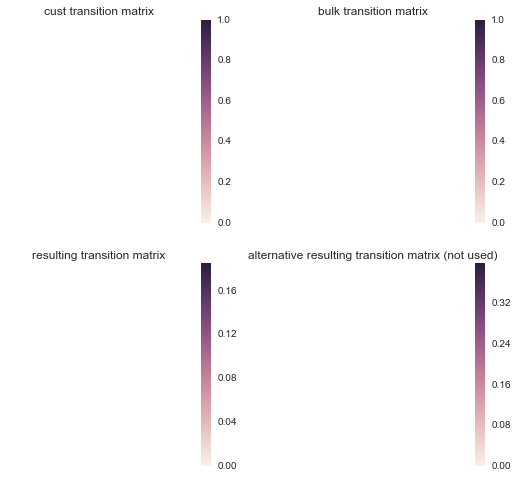

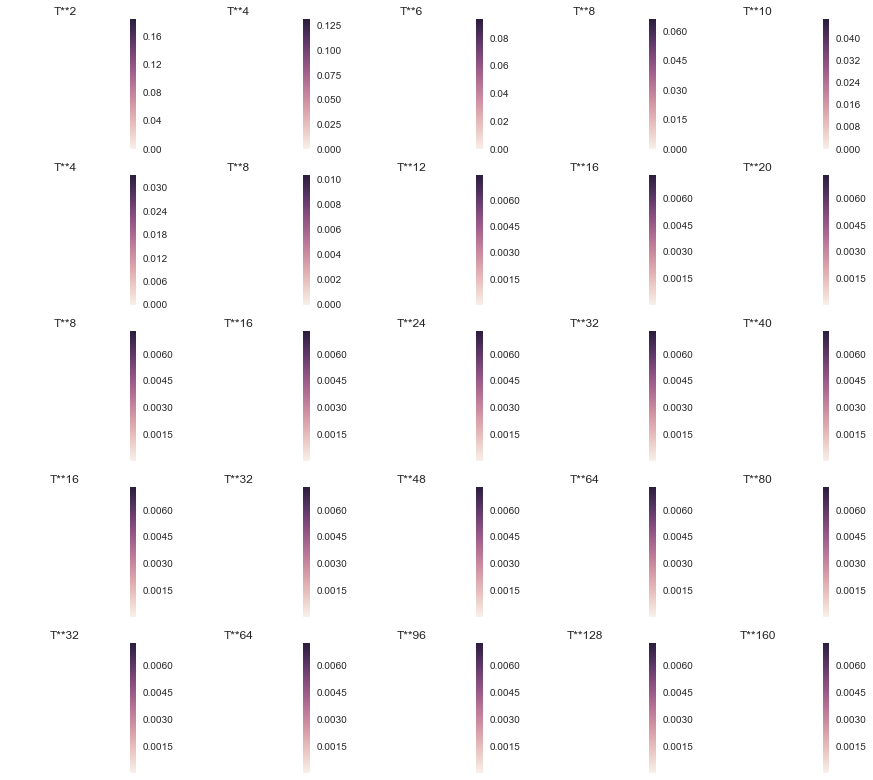

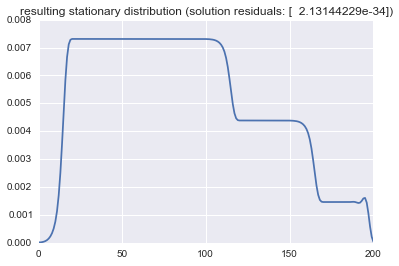

In [7]:
params_balanced = {
    
    "max_stock": 200,

    "n_customers": 500,
    "sim_buy_mean_period_days": 10,
    "n_pos": 10,


    # distribution of the purchased sim bulk sizes
    # this should normally be much smaller than max_stock 
    "bulk_size_distro" :{       
       100: .4,
       150: .4,
       200: .2
    },

    "bulk_trigger_params": {
        "x_min": 1,
        "x_max": 20,
        "shape": .2
    }    
}

show_convergence(params_balanced)    

Daily SIMs sold to customer by each POS should follow a Binomial(50, 0.0666666666667)
Daily SIMs sold to customer by each POS should follow a Binomial(50, 0.0666666666667)


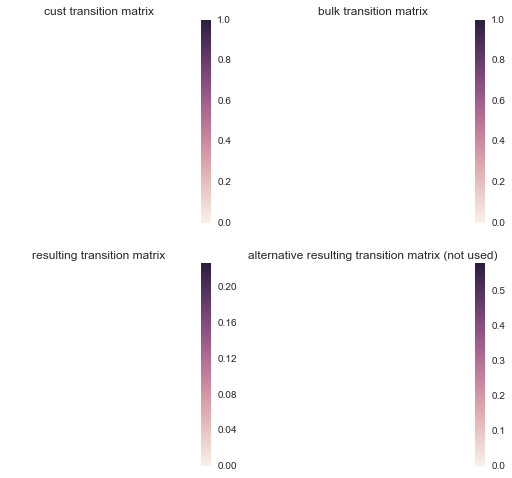

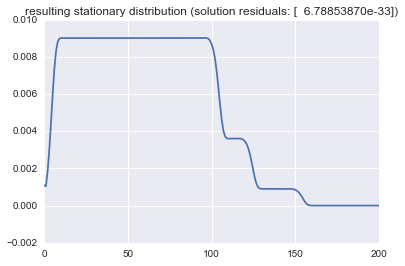

In [15]:
show_convergence({
    
    "max_stock": 200,

    "n_customers": 500,
    "sim_buy_mean_period_days": 10,
    "n_pos": 15,


    # distribution of the purchased sim bulk sizes
    # this should normally be much smaller than max_stock 
    "bulk_size_distro" :{       
       100: .6,
       120: .3,
       150: .1
        
    },

    "bulk_trigger_params": {
        "x_min": 1,
        "x_max": 10,
        "shape": 2
    }    
})    